# Scikit-Learn을 이용한 손글씨 숫자(Digits) 데이터 분석 및 분류

이 노트북은 Scikit-Learn에서 제공하는 `load_digits` 데이터셋을 활용하여 데이터를 분석하고, 다양한 머신러닝 모델을 통해 숫자를 분류하는 과정을 담고 있습니다.

## 데이터셋 설명: `load_digits`
- **데이터 구성**: 0부터 9까지의 손글씨 숫자 이미지 데이터셋입니다.
- **이미지 크기**: 8x8 픽셀 (총 64개의 특성)
- **샘플 수**: 총 1,797개
- **특성(Features)**: 각 픽셀의 밝기를 나타내는 0~16 사이의 정수값
- **타겟(Target)**: 해당 이미지가 나타내는 숫자 (0~9)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 시각화 설정
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 깨짐 방지 (Windows 기준)
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 로드 및 탐색적 데이터 분석 (EDA)

In [3]:
# 데이터 로드
digits = load_digits()
X = digits.data
y = digits.target

print(f"데이터 크기: {X.shape}")
print(f"타켓 클래스: {np.unique(y)}")

데이터 크기: (1797, 64)
타켓 클래스: [0 1 2 3 4 5 6 7 8 9]


In [4]:
 df = pd.DataFrame(data=load_digits().data, columns=load_digits().feature_names)
 df['target'] = load_digits().target
 df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [ ]:
# target별로 데이터의 갯수 확인
df['target'].value_counts().sort_values()

target
8    174
2    177
0    178
7    179
9    180
4    181
6    181
1    182
5    182
3    183
Name: count, dtype: int64

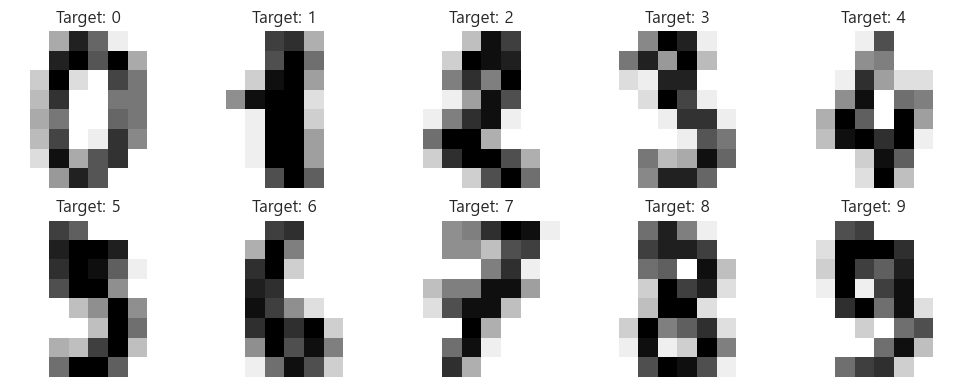

In [7]:
# 일부 데이터 시각화
plt.figure(figsize=(10, 4))
for index, (image, label) in enumerate(zip(digits.images[:10], digits.target[:10])):
    plt.subplot(2, 5, index + 1)
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Target: {label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

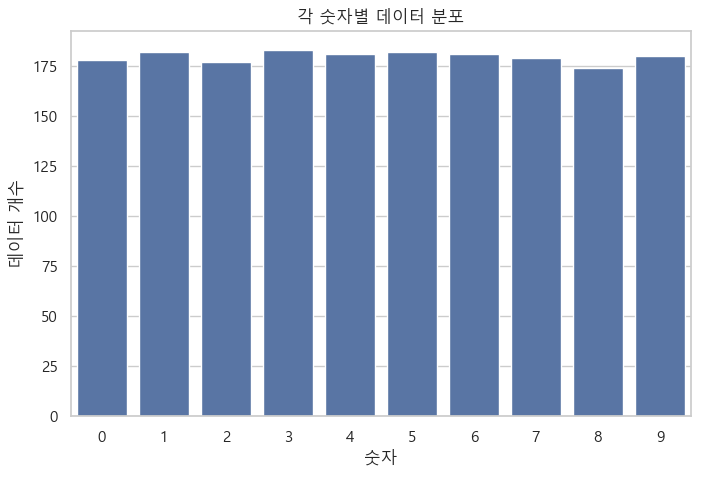

In [8]:
# 타겟 데이터 분포 확인
plt.figure(figsize=(8, 5))
sns.countplot(x=y)
plt.title('각 숫자별 데이터 분포')
plt.xlabel('숫자')
plt.ylabel('데이터 개수')
plt.show()

## 2. 데이터 전처리 및 특성 엔지니어링

In [11]:
# X.describe()
df.describe()


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


우리 아이는 표준화를 안해주네요^^

In [12]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 정규화 (Standard Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"학습 데이터 크기: {X_train_scaled.shape}")
print(f"테스트 데이터 크기: {X_test_scaled.shape}")

학습 데이터 크기: (1437, 64)
테스트 데이터 크기: (360, 64)


In [17]:
#  y_train의 레이블별 데이터 갯수 세기
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print("y_train의 레이블별 데이터 갯수:", unique, counts)
# print(dict(zip(unique, counts)))



y_train의 레이블별 데이터 갯수: [0 1 2 3 4 5 6 7 8 9] [142 146 142 146 145 145 145 143 139 144]


## 3. 모델링 및 하이퍼 파라미터 튜닝
6가지 모델을 사용하여 성능을 비교합니다.

In [13]:
# 모델 및 하이퍼파라미터 그리드 정의
models = {
    'Logistic Regression': (LogisticRegression(max_iter=10000), {'C': [0.1, 1, 10]}),
    'Random Forest': (RandomForestClassifier(random_state=42), {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
    'SVM': (SVC(probability=True, random_state=42), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {'max_depth': [None, 5, 10, 15]}),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42), {'n_estimators': [100, 150], 'learning_rate': [0.1, 0.05]})
}

best_models = {}
results = []

for name, (model, params) in models.items():
    print(f"{name} 튜닝 중...")
    grid = GridSearchCV(model, params, cv=3, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    
    best_model = grid.best_estimator_
    score = grid.best_score_
    
    best_models[name] = best_model
    results.append({'Model': name, 'Best Score': score})

results_df = pd.DataFrame(results).sort_values(by='Best Score', ascending=False)
print("\n--- 모델 성능 순위 ---")
print(results_df)

Logistic Regression 튜닝 중...
Random Forest 튜닝 중...
SVM 튜닝 중...
KNN 튜닝 중...
Decision Tree 튜닝 중...
Gradient Boosting 튜닝 중...

--- 모델 성능 순위 ---
                 Model  Best Score
2                  SVM    0.980515
1        Random Forest    0.970772
3                  KNN    0.970772
0  Logistic Regression    0.965901
5    Gradient Boosting    0.961726
4        Decision Tree    0.846903


## 4. 상위 4개 모델 추리기 및 앙상블 모델 생성

In [18]:
# 상위 4개 모델 선택
top_4_names = results_df.head(4)['Model'].values
estimators = [(name, best_models[name]) for name in top_4_names]

print(f"앙상블에 사용될 상위 4개 모델: {list(top_4_names)}")

# 보팅 앙상블 (Soft Voting)
ensemble_model = VotingClassifier(estimators=estimators, voting='soft')
ensemble_model.fit(X_train_scaled, y_train)

앙상블에 사용될 상위 4개 모델: ['SVM', 'Random Forest', 'KNN', 'Logistic Regression']


,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('SVM', ...), ('Random Forest', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'auto'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0


## 5. 모델 평가

In [19]:
# 앙상블 모델 예측 및 평가
y_pred = ensemble_model.predict(X_test_scaled)
accuracy = ensemble_model.score(X_test_scaled, y_test)

print(f"앙상블 모델의 테스트 정확도: {accuracy:.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

Exception in thread Thread-54 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\user\miniconda3\envs\DS\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\user\miniconda3\envs\DS\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\user\miniconda3\envs\DS\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 4: invalid start byte


앙상블 모델의 테스트 정확도: 0.9889

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.95      0.97      0.96        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       1.00      1.00      1.00        36
           8       0.97      0.94      0.96        35
           9       1.00      1.00      1.00        36

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



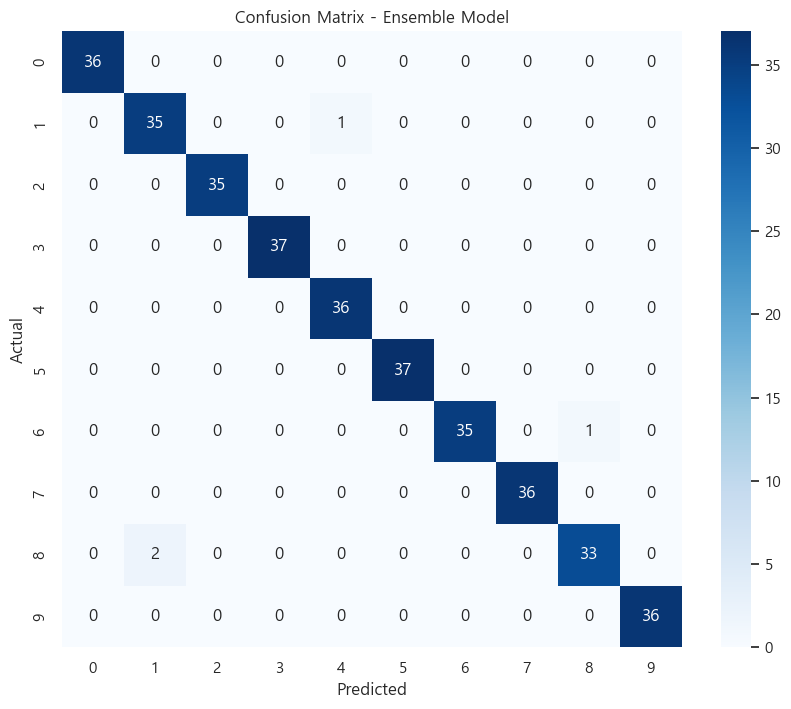

In [20]:
# Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Ensemble Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()